<a href="https://colab.research.google.com/github/zzf7ktx/test_git/blob/main/ai_workshop.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
%%capture
!pip install rembg
!pip install onnxruntime

In [3]:
from rembg import remove
from PIL import Image

In [4]:
def remove_background(path):
  input_image = Image.open(path)
  output_image = remove(input_image)
  return output_image

In [5]:
image_path = ['img1.jfif', 'img2.jfif', 'img3.jfif']
image_without_background_list = [remove_background(path) for path in image_path]

FileNotFoundError: [Errno 2] No such file or directory: 'img1.jfif'

In [ ]:
from IPython.display import display
display(image_without_background_list[2])

In [ ]:
background_color = '#F2DFDB'
size = (1024, 1024)

In [ ]:
new_background = Image.new('RGB', size, background_color)

In [ ]:
padding = 50
gap = 20
n_items = 3
image_w = ((size[0] - padding * 2) - gap * (n_items - 1)) / n_items
image_w = int(image_w)

In [ ]:
for i, img in enumerate(image_without_background_list):
  w, h = img.size
  image_h = int(image_w * h / w)
  img = img.resize((image_w, image_h))
  new_background.paste(img, (padding + i * (image_w + gap), int((size[1]/2 - image_h)/2 + size[1]/2)), img)
display(new_background)

In [ ]:
brand_name = "Deals With Jessica"
brand_name_position = (50, 50)
brand_name_color = (0, 0, 0)
brand_name_size = 100
brand_name_font = "roboto.ttf"

In [ ]:
# font = ImageFont.truetype(brand_name_font, brand_name_size)
font = ImageFont.load_default(brand_name_size)

In [37]:
new_image_with_brand_name = new_background.copy()
draw = ImageDraw.Draw(new_image_with_brand_name)
brand_name_bbox = draw.textbbox((0, 0), brand_name, font=brand_name_font)
brand_name_width = brand_name_bbox[2] - brand_name_bbox[0]
brand_name_height = brand_name_bbox[3] - brand_name_bbox[1]

AttributeError: 'str' object has no attribute 'getbbox'

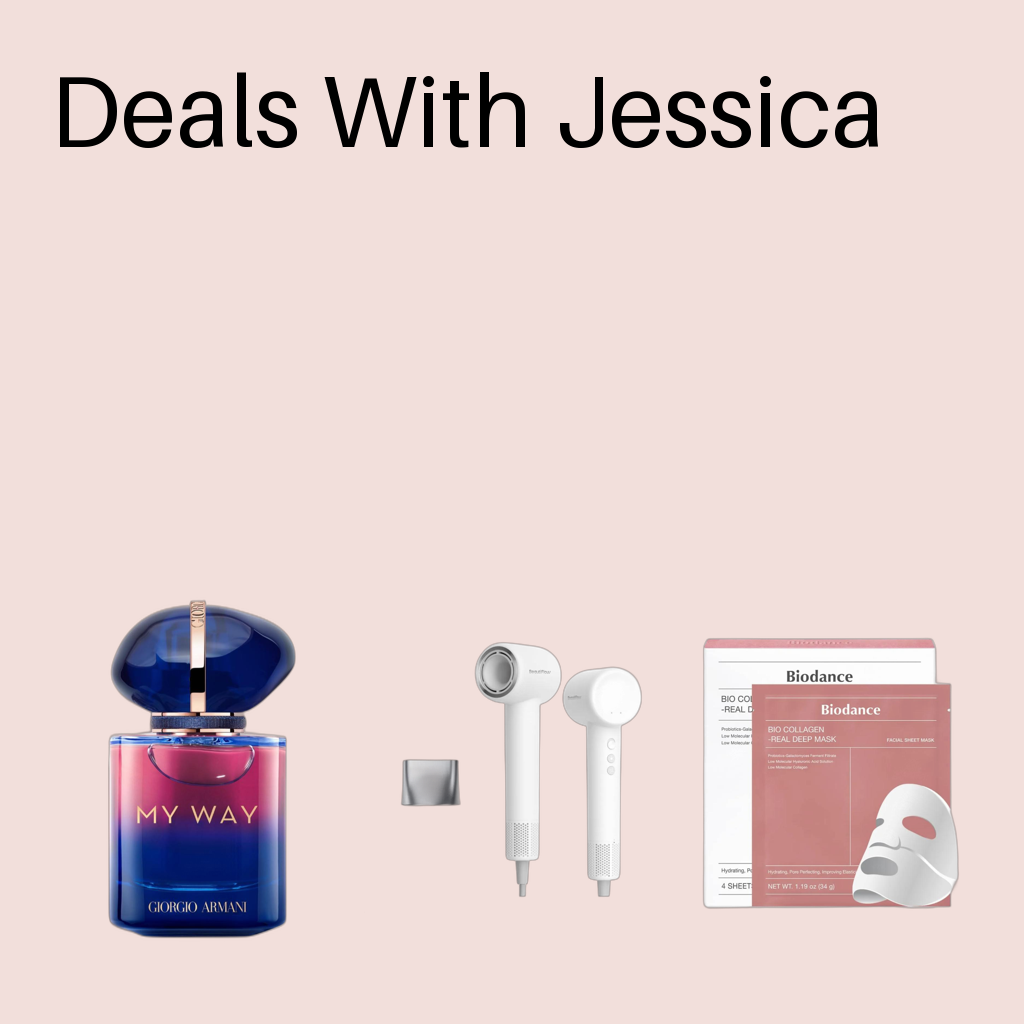

In [34]:
from PIL import ImageDraw, ImageFont

new_image_with_brand_name = new_background.copy()
draw = ImageDraw.Draw(new_image_with_brand_name)

# font = ImageFont.truetype(brand_name_font, brand_name_size)
font = ImageFont.load_default(brand_name_size)

draw.text(brand_name_position, brand_name, fill=brand_name_color, font=font)
new_image_with_brand_name.save('image_with_brand.png')
display(new_image_with_brand_name)